# "Topic" Modelling

Instead of modelling the stats of a pokemon as a joint normal distribution, we can treat it as an allocation of total attribute points according to the "theme" of the pokemon, i.e. its type.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt
from theano import shared
import theano as th

Load the Pokemon data:

In [2]:
pokemon = pd.read_csv("./Pokemon.csv")

Let us clean up the data. We fill Type 2 with Type 1 if the poekmon has only one type. We also convert the types into numerical IDs.

In [3]:
df = pokemon[['Type 1', 'Type 2', 'Legendary', 'Total', 'HP', 'Attack', 'Defense',
              'Sp. Atk', 'Sp. Def', 'Speed']].copy()
df['Single'] = pd.isnull(df['Type 2'])
df.loc[pd.isnull(df['Type 2']), 'Type 2'] = df[pd.isnull(df['Type 2'])]['Type 1']
cata1 = df['Type 1'].astype('category').cat
cata1_map = {cata1.categories[i]:i for i in range(len(cata1.categories))}
df['Type 1'] = df['Type 1'].apply(lambda x: cata1_map[x])
df['Type 2'] = df['Type 2'].apply(lambda x: cata1_map[x])
df.head()

,Type 1,Type 2,Legendary,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Single
0,9,13,False,318,45,49,49,65,65,45,False
1,9,13,False,405,60,62,63,80,80,60,False
2,9,13,False,525,80,82,83,100,100,80,False
3,9,13,False,625,80,100,123,122,120,80,False
4,6,6,False,309,39,52,43,60,50,65,True


In [4]:
df.describe()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.000000,800.00000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,9.467500,9.27750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,5.580356,4.83474,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,0.000000,0.00000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,5.000000,6.00000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,10.000000,9.00000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,14.000000,13.00000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,17.000000,17.00000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


In [5]:
labels = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

Dimensionality constants:

In [6]:
M = 6
T = 18

In [7]:
# debugging functions
from theano import printing, function
# printing_op = printing.Print('vector', attrs = [ 'shape' ])
# printing_op = printing.debugprint(n_amplified)
# printed_x = printing_op(n_amplified)

Now let us define our model.

In [9]:
type_ph = shared(df[['Type 1', 'Type 2']].values)
leg_ph = shared(df['Legendary'].astype(np.int32).values)
attr_ph = shared(df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].values)
N = df.shape[0]

with pm.Model() as model:
    
    amp = pm.Uniform("amp", 50., 300.)
    n = pm.Normal("n", np.ones(T) * 400., 50., shape=T)
#     r = 10. + pm.HalfNormal("r", 10., shape=(T, M))
    r = pm.Uniform("r", 5, 100, shape=(T, M))
    
    n_actual = 0.5 * (n[type_ph[:, 0]] + n[type_ph[:, 1]])
    n_amplified = n_actual + leg_ph * amp
    
    w0 = pm.Dirichlet("w0", r[type_ph[:, 0], :], shape=(N, M))
    w1 = pm.Dirichlet("w1", r[type_ph[:, 1], :], shape=(N, M))
    w = pm.Deterministic("w", (w0 + w1) / 2.)
    
    sigma = pm.Uniform("sigma", 10., 30.)
    y = pm.Normal("att", tt.reshape(n_amplified, (n_amplified.shape[0], 1)) * w, sigma, observed=attr_ph)

$$
K \sim Uniform(a_K, b_K) \\
N_{i} \sim Normal(\mu_{i}, \mu_{i}) \\
R_{i, j} \sim c + Uniform(m_R, n_R) \\
N_{actual} = \dfrac{R_{type_1, :} 1+ R_{type_2, :}}{2} \\
N_{amplified} = N_{actual} + KI_{legendary} \\
W_i \sim Dirichlet(r_{type_i, :}) \\
W = \dfrac{W_0 + W_1}{2} \\
\sigma_Y \sim Uniform(a_{\sigma_Y}, b_{\sigma_Y}) \\
Y \sim Normal(N_{amplified} \cdot W, \sigma_Y)
$$

In [10]:
with model:
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [11:51<00:00,  2.82it/s]


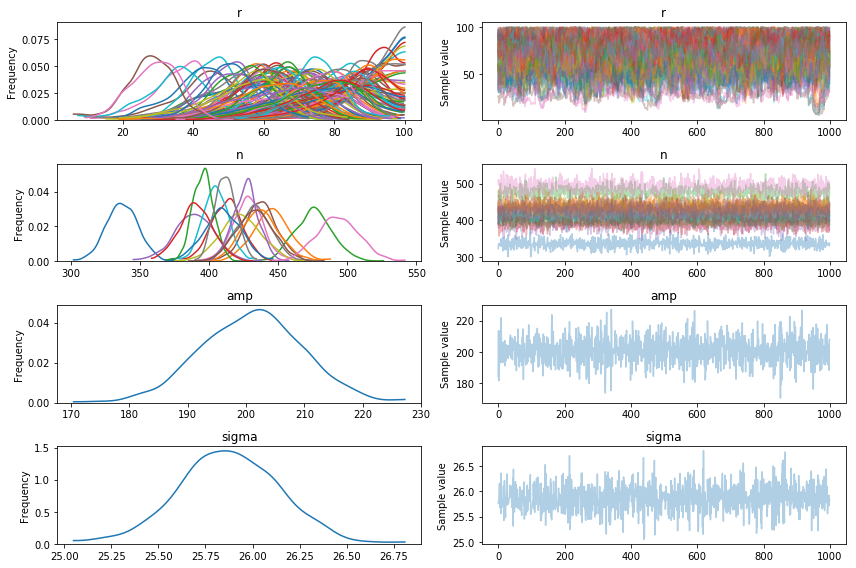

In [11]:
pm.traceplot(trace, varnames=['r', 'n', 'amp', 'sigma'])
plt.show()

Distribution of attributes by pokemon type:

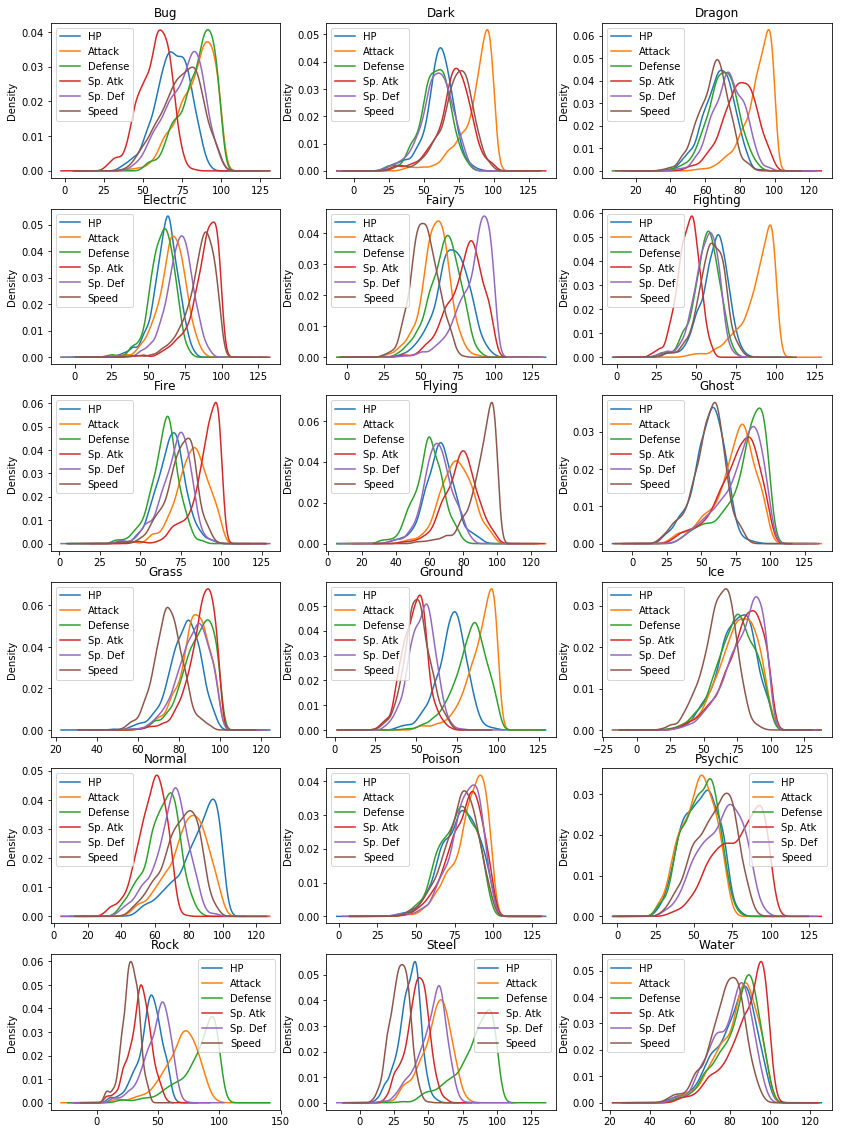

In [12]:
f, ax = plt.subplots(nrows=6, ncols=3, figsize=(14, 20))
for t in range(len(cata1.categories)):
    sel_tr = pd.DataFrame(trace['r'][:, t, :], columns=labels)
    ax[t//3, t%3].set_title(cata1.categories[t])
    sel_tr.plot.kde(ax=ax[t//3, t%3])

In [13]:
with model:
    samp = pm.sample_ppc(trace, samples=1000)

100%|██████████| 1000/1000 [00:01<00:00, 847.71it/s]


In [14]:
pd.DataFrame(samp['att'].reshape(-1, 6), columns=labels).agg([np.mean, np.std, 
                                                              lambda x: x.quantile(0.05),
                                                              lambda x: x.quantile(0.95)])

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
mean,68.855803,78.642762,73.323363,72.577917,71.503776,68.016175
std,28.618727,30.838970,31.907963,31.912345,29.328875,30.179659
<lambda>,22.489093,29.557158,23.909924,21.993326,24.608129,19.626563
<lambda>,116.586984,130.980025,127.933264,126.846183,120.876623,118.717008


In [15]:
df[labels].agg([np.mean, np.std, lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)])

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
<lambda>,35.950000,30.000000,35.000000,30.000000,32.950000,25.000000
<lambda>,110.000000,136.200000,130.000000,131.050000,120.000000,115.000000


Comparing data distribution and posterior distribution of the model (blue - posterior, red - data, green - data for legdndary):

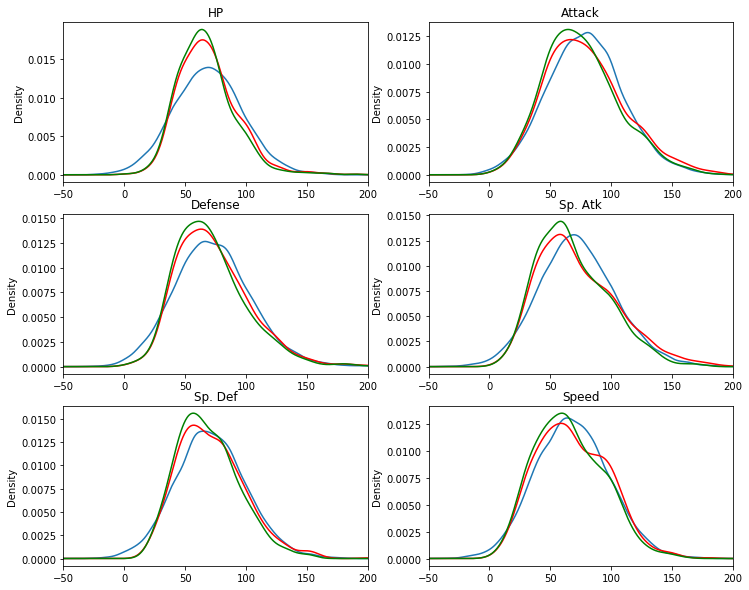

In [16]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
tdf = pd.DataFrame(samp['att'].reshape(-1, 6))
for i in range(3):
    for j in range(2):
        tdf.iloc[:, 2 * i + j].sample(10000).plot.kde(xlim=(-50, 200), 
                                        title=labels[2 * i + j], 
                                        ax=ax[i, j])
tdf = pd.DataFrame(df[labels])
for i in range(3):
    for j in range(2):
        tdf.iloc[:, 2 * i + j].plot.kde(xlim=(-50, 200), 
                                        title=labels[2 * i + j],
                                        ax=ax[i, j], color='red')
tdf = pd.DataFrame(df.query('Legendary == False')[labels])
for i in range(3):
    for j in range(2):
        tdf.iloc[:, 2 * i + j].plot.kde(xlim=(-50, 200), 
                                        title=labels[2 * i + j],
                                        ax=ax[i, j], color='green')
plt.show()

Now let us find the most unusual (and most ordinary) pokemons:

In [19]:
with model:
    logp = y.logp_elemwise(
        amp_interval__=trace['amp_interval__'].mean(axis=0),
        n=trace['n'].mean(axis=0),
        w0_stickbreaking__=trace['w0_stickbreaking__'].mean(axis=0),
        w1_stickbreaking__=trace['w1_stickbreaking__'].mean(axis=0),
        sigma_interval__=trace['sigma_interval__'].mean(axis=0),
        r_interval__=trace['r_interval__'].mean(axis=0),
    )

Find lowest log probability:

In [20]:
sort_ind = np.argsort(np.prod(logp, axis=1))

In [21]:
pokemon.iloc[sort_ind[:20], :]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
550,492,ShayminLand Forme,Grass,NaN,600,100,100,100,100,100,100,4,True
281,259,Marshtomp,Water,Ground,405,70,85,70,60,70,50,3,False
325,301,Delcatty,Normal,NaN,380,70,65,65,55,55,70,3,False
391,358,Chimecho,Psychic,NaN,425,65,50,70,95,80,65,3,False
38,33,Nidorino,Poison,NaN,365,61,72,57,55,55,65,1,False
262,243,Raikou,Electric,NaN,580,90,85,75,115,100,115,2,True
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
170,156,Quilava,Fire,NaN,405,58,64,58,80,65,80,2,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
561,502,Dewott,Water,NaN,413,75,75,60,83,60,60,5,False


Find highest log probability:

In [22]:
pokemon.iloc[sort_ind[::-1][:20], :]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
230,213,Shuckle,Bug,Rock,505,20,10,230,10,230,5,2,False
261,242,Blissey,Normal,NaN,540,255,10,10,75,135,55,2,False
121,113,Chansey,Normal,NaN,450,250,5,5,35,105,50,1,False
429,386,DeoxysAttack Forme,Psychic,NaN,600,50,180,20,180,20,150,3,True
313,289,Slaking,Normal,NaN,670,150,160,100,95,65,100,3,False
217,202,Wobbuffet,Psychic,NaN,405,190,33,58,33,58,33,2,False
19,15,BeedrillMega Beedrill,Bug,Poison,495,65,150,40,15,80,145,1,False
789,713,Avalugg,Ice,NaN,514,95,117,184,44,46,28,6,False
268,248,TyranitarMega Tyranitar,Rock,Dark,700,100,164,150,95,120,71,2,False
87,80,SlowbroMega Slowbro,Water,Psychic,590,95,75,180,130,80,30,1,False


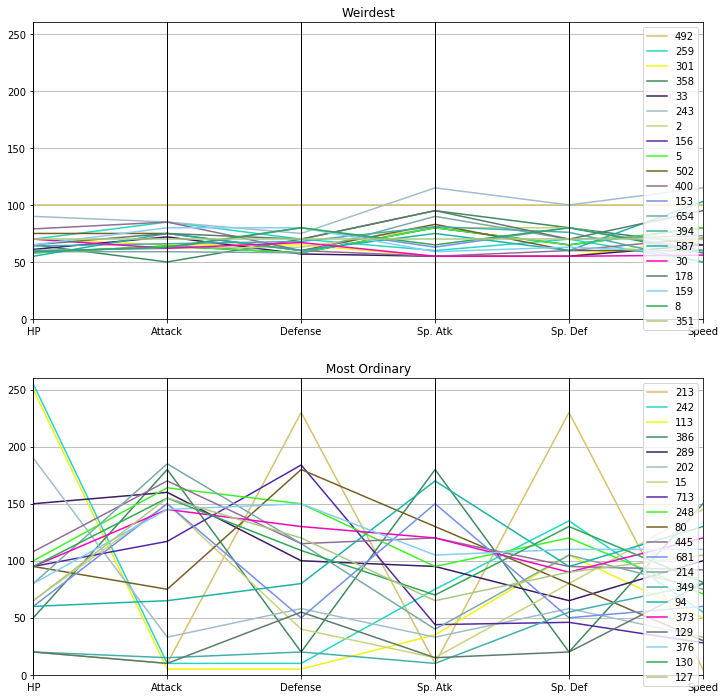

In [23]:
f, ax = plt.subplots(figsize=(12, 12), nrows=2)
melted = pokemon.iloc[sort_ind[:20], [0,5,6,7,8,9,10]].melt(id_vars="#")
pd.plotting.parallel_coordinates(pokemon.iloc[sort_ind[:20], [0,5,6,7,8,9,10]], class_column='#', ax=ax[0])
ax[0].axes.set_ylim(0, 260)
ax[0].set_title("Weirdest")
melted = pokemon.iloc[sort_ind[::-1][:20], [0,5,6,7,8,9,10]].melt(id_vars="#")
pd.plotting.parallel_coordinates(pokemon.iloc[sort_ind[::-1][:20], [0,5,6,7,8,9,10]], class_column='#', ax=ax[1])
ax[1].axes.set_ylim(0, 260)
ax[1].set_title("Most Ordinary")
plt.show()

As we see here, because we chose a different model with different priors than the multivariate normal model, the log probability ranking of pokemons is almost the opposite of the normal distribution model. Here, pokemons with wildly uneven attribute allocations are considered ordinary, whereas pokemons with very even attribute allocations are considered unusual. This is mainly due to the effect of the Dirichlet prior, which prefers allocating more weights to the dominant attribute.

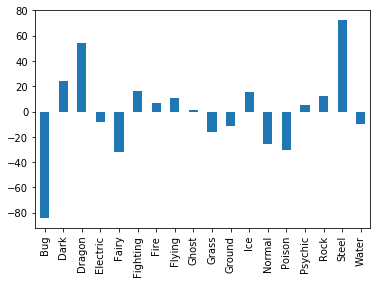

In [24]:
ms = pd.DataFrame(trace['n'], columns=cata1.categories).mean()
(ms - ms.mean()).plot.bar()
plt.show()

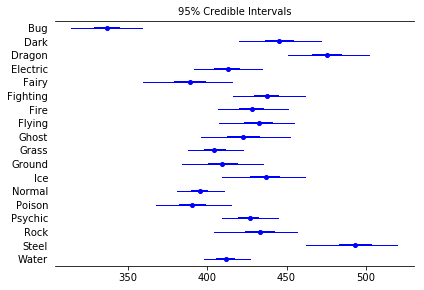

In [25]:
pm.plots.forestplot(trace, varnames=['n'], ylabels=cata1.categories)
plt.show()